In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT
import pickle

from analysis import PandasAnalysis

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = glob.glob("../analysis/studies/onelep/output/Run2/*.root")
babies

['../analysis/studies/onelep/output/Run2/VHToNonbb.root',
 '../analysis/studies/onelep/output/Run2/TTbar2L.root',
 '../analysis/studies/onelep/output/Run2/Bosons.root',
 '../analysis/studies/onelep/output/Run2/TTbar1L.root',
 '../analysis/studies/onelep/output/Run2/TTX.root',
 '../analysis/studies/onelep/output/Run2/WJets.root',
 '../analysis/studies/onelep/output/Run2/VBSWH_mkW.root']

In [3]:
vbswh = PandasAnalysis(
    sig_root_files=babies[-1:],
    bkg_root_files=babies[:-1],
    ttree_name="tree",
    weight_columns=["xsec_sf"]
)

In [4]:
vbswh.make_selection("M_jj > 1500 and abs(deta_jj) > 5 and ST > 500")
vbswh.set_split_column(ratio=0.75, name="split")

In [5]:
vbswh.df["abs_deta_jj"] = np.abs(vbswh.df.deta_jj)
vbswh.df.columns

Index(['lep_pdgID', 'lep_pt', 'lep_eta', 'lep_phi', 'LT', 'hbbjet_score',
       'hbbjet_pt', 'hbbjet_eta', 'hbbjet_phi', 'hbbjet_mass',
       'hbbjet_msoftdrop', 'xsec_sf', 'event', 'MET', 'ST', 'lep_sf',
       'lep_sf_up', 'lep_sf_dn', 'HT', 'n_jets_pt30', 'n_fatjets',
       'n_loose_b_jets', 'n_medium_b_jets', 'n_tight_b_jets', 'ld_vbs_jet_pt',
       'tr_vbs_jet_pt', 'M_jj', 'deta_jj', 'dR_jj', 'name', 'is_signal',
       'event_weight', 'split', 'split_weight', 'abs_deta_jj'],
      dtype='object')

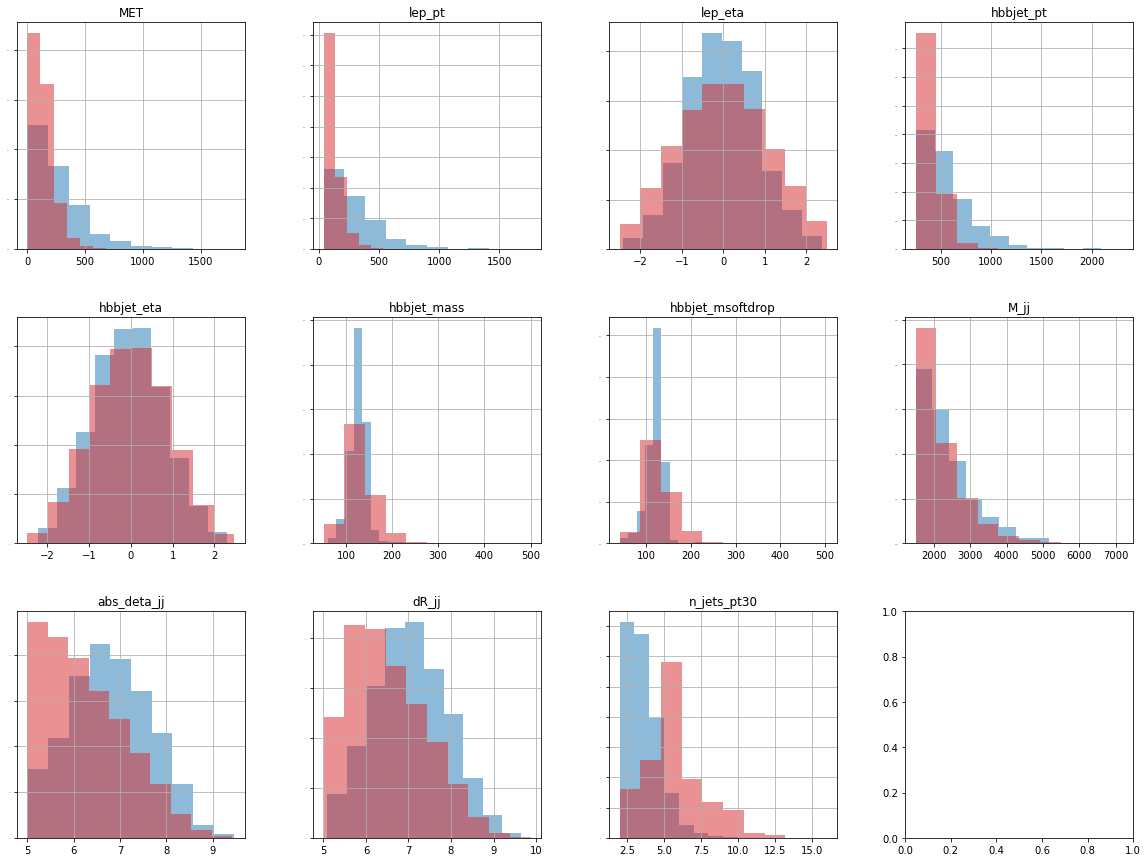

In [6]:
# # Select features
features = [
    "MET",
    "lep_pt",
    "lep_eta",
#     "hbbjet_score",
    "hbbjet_pt",
    "hbbjet_eta",
    "hbbjet_mass",
    "hbbjet_msoftdrop",
    "M_jj",
    "abs_deta_jj",
    "dR_jj",
    "n_jets_pt30"
]

# Plot feature shapes
fig, axes = plt.subplots(3,4,figsize=(20,15))

sig_df = vbswh.sig_df()
bkg_df = vbswh.bkg_df()

ax = sig_df[features].hist(
    ax=axes.flatten()[:len(features)],
    alpha=0.5, color="C0", ylabelsize=0, 
    density=True
)
ax = bkg_df[features].hist(
    ax=axes.flatten()[:len(features)], 
    alpha=0.5, color="C3", ylabelsize=0, 
    density=True
)

In [7]:
train_df = vbswh.df[vbswh.df.split].sample(frac=1.)
test_df = vbswh.df[~vbswh.df.split].sample(frac=1.)

# BDT Input
dtest = xgb.DMatrix(
    test_df[features], 
    label=test_df.is_signal,
    weight=np.abs(test_df.split_weight)
)
dtrain = xgb.DMatrix(
    train_df[features], 
    label=train_df.is_signal, 
    weight=np.abs(train_df.split_weight)
)
evallist = [(dtrain, "train"), (dtest, "eval")]

# BDT Parameters Setup
params = {}
params["objective"] = "binary:logistic"

# BDT Knobs (Parameters)
num_round = 500                  # Number of training rounds
params["eta"] = 0.1              # Step size shrinkage (alias: learning_rate)
params["max_depth"] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
params["verbosity"] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
params["nthread"] = 8            # Number of parallel threads
params["eval_metric"] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
params["subsample"] = 0.6        # Subsample ratio of the training instances
params["alpha"] = 8.0            # L1 regularization term on weights: Larger = more conservative
params["gamma"] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
params["lambda"] = 1.0           # L2 regularization term on weights: Larger = more conservative
params["min_child_weight"] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
params["colsample_bytree"] = 1.0 # The subsample ratio of columns when constructing each tree
# params["base_score"] = 0.1       # The initial prediction score of all instances, global bias

# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label() == 1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label() == 0]).sum()
# Control the balance of positive and negative weights, useful for unbalanced classes
# A typical value to consider: sum(negative instances) / sum(positive instances)
params["scale_pos_weight"] = sumw_neg/sumw_pos

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [8]:
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=True)

[0]	train-auc:0.91984	eval-auc:0.90768
[1]	train-auc:0.94234	eval-auc:0.93578
[2]	train-auc:0.94059	eval-auc:0.93384
[3]	train-auc:0.94521	eval-auc:0.93829
[4]	train-auc:0.94629	eval-auc:0.93953
[5]	train-auc:0.94949	eval-auc:0.94087
[6]	train-auc:0.94964	eval-auc:0.94091
[7]	train-auc:0.95131	eval-auc:0.94189
[8]	train-auc:0.95198	eval-auc:0.94397
[9]	train-auc:0.95231	eval-auc:0.94418
[10]	train-auc:0.95331	eval-auc:0.94562
[11]	train-auc:0.95617	eval-auc:0.95041
[12]	train-auc:0.95606	eval-auc:0.94993
[13]	train-auc:0.95655	eval-auc:0.95075
[14]	train-auc:0.95669	eval-auc:0.95130
[15]	train-auc:0.95812	eval-auc:0.95240
[16]	train-auc:0.95848	eval-auc:0.95248
[17]	train-auc:0.95890	eval-auc:0.95290
[18]	train-auc:0.95978	eval-auc:0.95388
[19]	train-auc:0.95983	eval-auc:0.95389
[20]	train-auc:0.95992	eval-auc:0.95412
[21]	train-auc:0.96020	eval-auc:0.95459
[22]	train-auc:0.96052	eval-auc:0.95485
[23]	train-auc:0.96161	eval-auc:0.95540
[24]	train-auc:0.96238	eval-auc:0.95639
[25]	train

In [9]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(train_df[features]))
preds_test = bst.predict(xgb.DMatrix(test_df[features]))

y_train = train_df.is_signal
y_test = test_df.is_signal

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


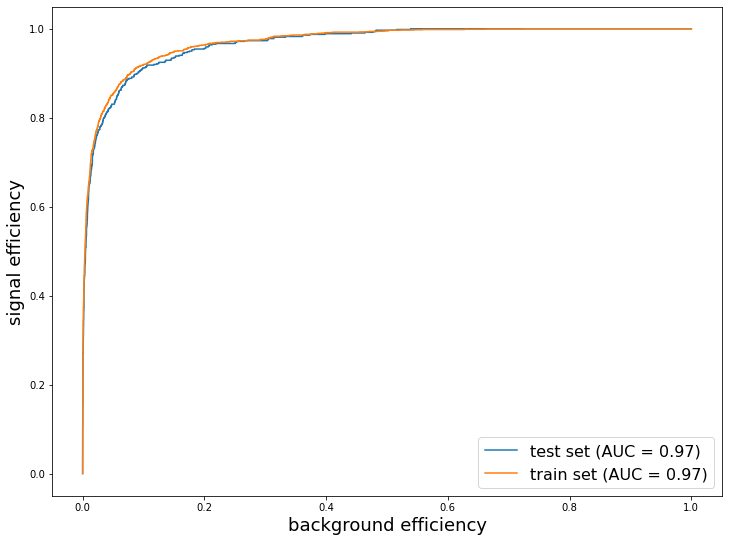

In [10]:
fig, axes = plt.subplots(figsize=(12,9))

# Test ROC Curve
fpr, tpr, thresh = roc_curve(test_df.is_signal, preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

# Train ROC Curve
fpr, tpr, thresh = roc_curve(train_df.is_signal, preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));

plt.xlabel("background efficiency", size=18);
plt.ylabel("signal efficiency", size=18);
plt.legend(fontsize=16);

In [11]:
vbswh.df["bdt"] = bst.predict(xgb.DMatrix(vbswh.df[features]))

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


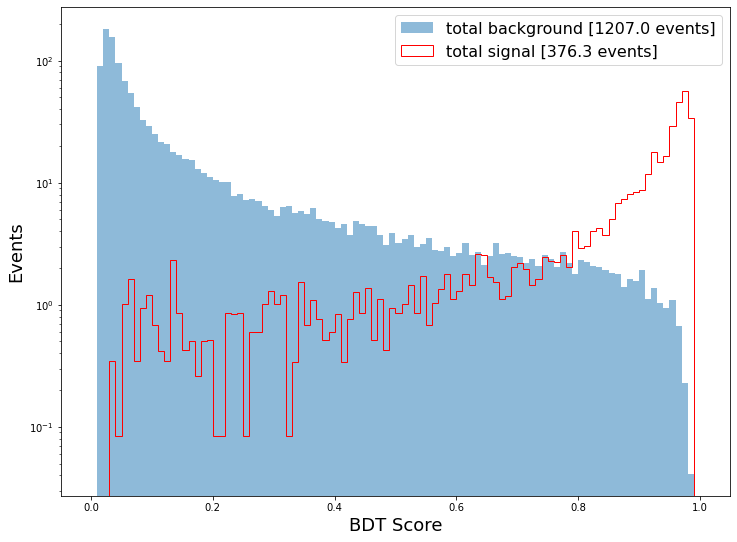

In [12]:
vbswh.plot_sig_vs_bkg("bdt", np.linspace(0, 1, 101), xlabel="BDT Score", logy=True)

In [13]:
vbswh.fom_scan("bdt", [0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98])

sel,sig,bkg,fom
bdt > 0.8,289.29775212705135,27.2193278186071,55.4506142148343
bdt > 0.9,235.7063572332263,8.428441063232867,81.18908910126412
bdt > 0.91,227.03639712929726,6.501211627729617,89.04270289825374
bdt > 0.92,215.27631172537804,5.385998049424643,92.76051438480175
bdt > 0.93,197.4095260053873,4.008383918139998,98.60148374614165
bdt > 0.94,182.57268808037043,2.970908440366884,105.92322036406713
bdt > 0.95,166.04456041008234,2.03070651884741,116.52015972297733
bdt > 0.96,136.64444870501757,0.9343969403744268,141.3599194280033
bdt > 0.97,90.71114514768124,0.26814727841701824,175.17573680589186
bdt > 0.98,33.870836183428764,0.0413858441170305,166.49454525153592


In [22]:
vbswh.fom_scan("hbbjet_score", [0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98], base_selection="bdt > 0.96")

sel,sig,bkg,fom
bdt > 0.96 and hbbjet_score > 0.91,135.62816942483187,0.754201983090752,156.17304033706796
bdt > 0.96 and hbbjet_score > 0.92,134.175905123353,0.7881697563025227,151.13486088336862
bdt > 0.96 and hbbjet_score > 0.93,132.55024778097868,0.6670824205248209,162.2896396507281
bdt > 0.96 and hbbjet_score > 0.94,130.6053906902671,0.5766283250159177,171.9939286635628
bdt > 0.96 and hbbjet_score > 0.95,128.72616600245237,0.5726114620665612,170.11273059825467
bdt > 0.96 and hbbjet_score > 0.96,126.7569015994668,0.57138066346306,167.69064894707805
bdt > 0.96 and hbbjet_score > 0.97,122.84946649521589,0.4853160663951712,176.34410261018238
bdt > 0.96 and hbbjet_score > 0.98,116.40467638522387,0.39622035075808526,184.92773001890373


In [15]:
for key, val in params.items():
    print(f"{key},{val}")

objective,binary:logistic
eta,0.1
max_depth,3
verbosity,1
nthread,8
eval_metric,auc
subsample,0.6
alpha,8.0
gamma,2.0
lambda,1.0
min_child_weight,1.0
colsample_bytree,1.0
scale_pos_weight,3.3119401931762695


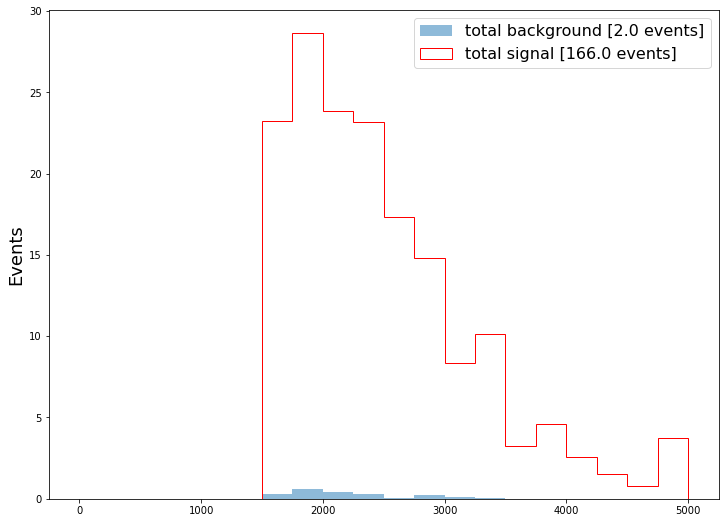

In [16]:
vbswh.plot_sig_vs_bkg("M_jj", np.linspace(0, 5000, 21), selection="bdt > 0.95")

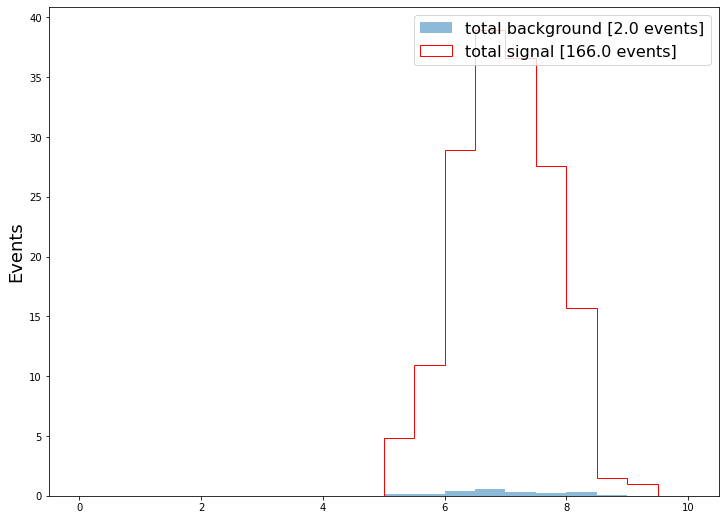

In [17]:
vbswh.plot_sig_vs_bkg("deta_jj", np.linspace(0, 10, 21), selection="bdt > 0.95", abs=True)

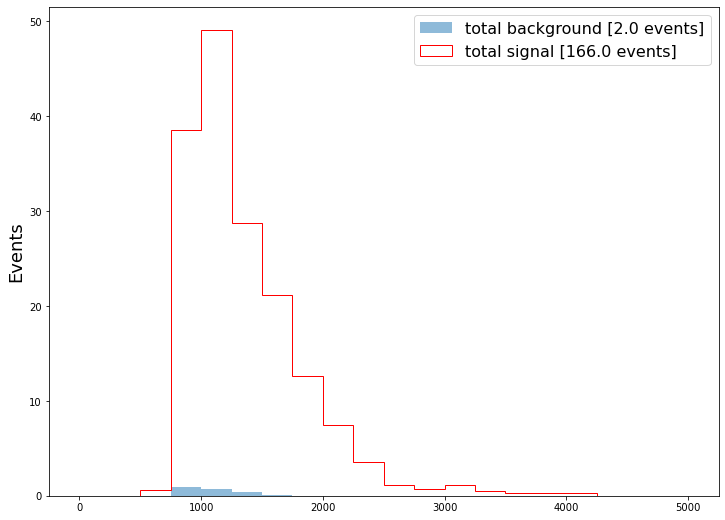

In [18]:
vbswh.plot_sig_vs_bkg("ST", np.linspace(0, 5000, 21), selection="bdt > 0.95")

In [19]:
vbswh.fom_scan("ST", [800, 900, 1000, 1100, 1200, 1300, 1400, 1500], base_selection="bdt > 0.95")

sel,sig,bkg,fom
bdt > 0.95 and ST > 800,161.88472708314657,1.976312426436607,115.15374770807388
bdt > 0.95 and ST > 900,146.91344533115625,1.6218376729896136,115.36069174283824
bdt > 0.95 and ST > 1000,126.90951943397522,1.0767957040018246,122.30030566504577
bdt > 0.95 and ST > 1100,103.09722278267145,0.6963719705902349,123.54532761965478
bdt > 0.95 and ST > 1200,85.17928419262171,0.4797383425939188,122.97923040841079
bdt > 0.95 and ST > 1300,72.37305729836226,0.31022359659618814,129.93899543708469
bdt > 0.95 and ST > 1400,60.635369308292866,0.09212215258230572,199.77631054470294
bdt > 0.95 and ST > 1500,49.07458172738552,0.047373992900247686,225.468882014617


In [26]:
# Write features list
with open("../analysis/studies/onelep/bdt_features.txt", "w") as txt_file:
    txt_file.write("\n".join(features))

# Write BDT model
pickle.dump(bst, open("../analysis/studies/onelep/bdt.pkl", "wb"))
bst.save_model("../analysis/studies/onelep/bdt.model")
bst.dump_model("../analysis/studies/onelep/bdt.json", "../analysis/studies/onelep/bdt_features.txt")